In [1]:
import numpy as np
import xml.etree.ElementTree as et
import os, glob, re
import tifffile, cv2
import openslide
import matplotlib.pyplot as plt

In [2]:
wsi_load_dir = './Training Data/X/'
xml_load_dir = './Training Data/Y_xml/'

wsi_fns = sorted(glob.glob(wsi_load_dir + '*.svs') + glob.glob(wsi_load_dir + '*.SVS'))
xml_fns = sorted(glob.glob(xml_load_dir + '*.xml') + glob.glob(xml_load_dir + '*.XML'))

save_dir = './Training Data/Y/'
os.makedirs(save_dir, exist_ok=True)

In [3]:
div = 16

assert len(wsi_fns) == len(xml_fns) == 47

q = re.compile('training_data_[0-9]{2}')

In [4]:
def xml2mask(xml_fn, shape):
  # print('reconstructing sparse xml to contours of div={}..'.format(div))
    board_pos = None
    board_neg = None
  # Annotations >> 
    e = et.parse(xml_fn).getroot()
    e = e.findall('Annotation')
    assert(len(e) == 1), len(e)
    for ann in e:
        board_pos = np.zeros(shape[:2], dtype=np.uint8)
        board_neg = np.zeros(shape[:2], dtype=np.uint8)
        id_num = int(ann.get('Id'))
        assert(id_num == 1)# or id_num == 2)
        regions = ann.findall('Regions')
        assert(len(regions) == 1)
        rs = regions[0].findall('Region')
        plistlist = list()
        nlistlist = list()
        print('rs:', len(rs))
        for i, r in enumerate(rs):
#             ylist = list()
#             xlist = list()
            plist, nlist = list(), list()
            negative_flag = int(r.get('NegativeROA'))
            assert negative_flag == 0 or negative_flag == 1
            negative_flag = bool(negative_flag)
            vs = r.findall('Vertices')[0]
            vs = vs.findall('Vertex')
            vs.append(vs[0]) # last dot should be linked to the first dot
            for v in vs:
                y, x = int(v.get('Y').split('.')[0]), int(v.get('X').split('.')[0])
                if div is not None:
                    y //= div
                    x //= div
                if y >= shape[0]:
                    y = shape[0]-1
                elif y < 0:
                    y = 0
                if x >= shape[1]:
                    x = shape[1]-1
                elif x < 0:
                    x = 0
#                 ylist.append(y)
#                 xlist.append(x)
                if negative_flag:
                    nlist.append((x, y))
                else:
                    plist.append((x, y))
            if plist:
                plistlist.append(plist)
            else:
                nlistlist.append(nlist)
        for plist in plistlist:
            board_pos = cv2.drawContours(board_pos, [np.array(plist, dtype=np.int32)], -1, [255, 255, 255], -1)
        for nlist in nlistlist:
            board_neg = cv2.drawContours(board_neg, [np.array(nlist, dtype=np.int32)], -1, [255, 255, 255], -1)
    return (board_pos>0) * (board_neg==0)

In [5]:
def save_mask(xml_fn, shape):
    wsi_id = xml_fn.split('/')[-1][:-4]
    save_fn = save_dir + '{}_l2_annotation_tumor.npy'.format(wsi_id)
    ret = xml2mask(xml_fn, shape)
#     tifffile.imwrite(save_fn, (ret[1]>0).astype(np.uint8), compress=9)
    np.save(save_fn, ret)
    return ret

In [6]:
def load_svs_shape(fn, level=2):
    imgh = openslide.OpenSlide(fn)
    return [imgh.level_dimensions[level][1], imgh.level_dimensions[level][0]]

In [7]:
for i, (wsi_fn, xml_fn) in enumerate(zip(wsi_fns, xml_fns)):
    wsi_id = q.findall(wsi_fn)[0]
    xml_id = q.findall(xml_fn)[0]
    assert wsi_id == xml_id
    assert os.path.isfile(wsi_fn) and os.path.isfile(xml_fn)
    print(i+1, '/', len(wsi_fns), ':', wsi_id)
    shape = load_svs_shape(wsi_fn, level=2)
    ret = save_mask(xml_fn, shape)

1 / 47 : training_data_01
rs: 3
2 / 47 : training_data_02
rs: 3
3 / 47 : training_data_03
rs: 1
4 / 47 : training_data_04
rs: 4
5 / 47 : training_data_05
rs: 1
6 / 47 : training_data_06
rs: 1
7 / 47 : training_data_07
rs: 1
8 / 47 : training_data_08
rs: 1
9 / 47 : training_data_09
rs: 4
10 / 47 : training_data_10
rs: 1
11 / 47 : training_data_11
rs: 1
12 / 47 : training_data_12
rs: 1
13 / 47 : training_data_13
rs: 4
14 / 47 : training_data_14
rs: 7
15 / 47 : training_data_15
rs: 2
16 / 47 : training_data_16
rs: 2
17 / 47 : training_data_17
rs: 2
18 / 47 : training_data_18
rs: 1
19 / 47 : training_data_19
rs: 2
20 / 47 : training_data_20
rs: 5
21 / 47 : training_data_21
rs: 1
22 / 47 : training_data_22
rs: 4
23 / 47 : training_data_23
rs: 1
24 / 47 : training_data_24
rs: 1
25 / 47 : training_data_25
rs: 2
26 / 47 : training_data_26
rs: 4
27 / 47 : training_data_27
rs: 1
28 / 47 : training_data_28
rs: 1
29 / 47 : training_data_29
rs: 1
30 / 47 : training_data_30
rs: 1
31 / 47 : training_

(5817, 7719)


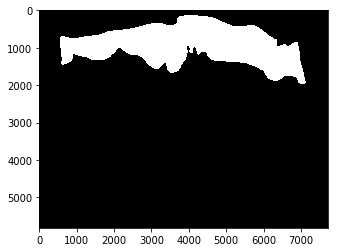

In [8]:
lst = ret[:,:]
print(lst.shape)
plt.imshow(lst*255, cmap='gray')